# Grid world path optimization using hybrid GA-ACO approach

## Importing modules

In [1]:
import os
from typing import Tuple, List

import matplotlib.pyplot as plt

from IPython.display import Video

import functions as fn
import simulations as sm

## Parameters

In [2]:
# Grid parameters
GRID_SIZE: Tuple[int, int] = (10, 15)
START_POSITION: Tuple[int, int] = (6, 1)
END_POSITION: Tuple[int, int] = (4, 13)
OBSTACLES: List[Tuple[int, int]] = [
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14),
    (1, 0), (1, 3), (1, 14), (2, 0), (2, 3), (2, 5), (2, 6), (2, 7), (2, 11), (2, 14), (3, 0), (3, 3), (3, 10), (3, 11), (3, 13), 
    (3, 14), (4, 0), (4, 3), (4, 9), (4, 10), (4, 11), (4, 14), (5, 0), (5, 3), (5, 6), (5, 11), (5, 13), (5, 14), (6, 0), (6, 6), 
    (6, 9), (6, 11), (6, 14), (7, 0), (7, 6), (7, 9), (7, 14), (8, 0), (8, 3), (8, 6), (8, 14), (9, 0), (9, 1), (9, 2), (9, 3), 
    (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14)
]
NUM_OPTIMAL_STEPS: int = 20

# Simulation parameters - Genetic Algorithms
CHROMOSOME_LENGTH: int = 64
POPULATION_SIZE: int = 100
NUM_GENERATIONS: int = 50
SELECTION_TYPE: str = "best to rest"
BIAS: int = 3
PROGRESSIVE_MUTATION: bool = True
MUTATION_RATE: float = 0.01
EARLY_STOP: bool = False
BEST_ONES_PERCENTAGE: float = 0.2
WORST_ONES_PERCENTAGE: float = 0.2
NUM_BEST_PATHS: int = 5
GA_REVISIT_POSSIBLE: bool = False

# Simulation parameters - Ant Colony Optimization
ALPHA: float = 2
BETA: int = 3
EVAPORATION_RATE: float = 0.5
DEPOSIT_FACTOR: int = 10
NUM_ANTS: int = 100
NUM_ITERATIONS: int = 1000
MAX_PATH_LENGTH: int = 32
ACO_REVISIT_POSSIBLE: bool = True
PHEROMONE_NORMALIZATION: bool = True
PATH_SCALING_FACTOR: int = 10
PHEROMONE_THRESHOLD: float = 0.25

# Visualization
WINDOW_SIZE: int = 10

# Paths
RESULTS_PATH: str = "./results"
GA_ACO_RESULTS_PATH: str = f"{RESULTS_PATH}/GA-ACO results"
if GA_REVISIT_POSSIBLE and ACO_REVISIT_POSSIBLE:
    GA_ACO_VERSION_PATH: str = f"{GA_ACO_RESULTS_PATH}/reentrant ga - reentrant aco"
elif not GA_REVISIT_POSSIBLE and ACO_REVISIT_POSSIBLE:
    GA_ACO_VERSION_PATH: str = f"{GA_ACO_RESULTS_PATH}/non-reentrant ga - reentrant aco"
elif GA_REVISIT_POSSIBLE and not ACO_REVISIT_POSSIBLE:
    GA_ACO_VERSION_PATH: str = f"{GA_ACO_RESULTS_PATH}/reentrant ga - non-reentrant aco"
elif not GA_REVISIT_POSSIBLE and not ACO_REVISIT_POSSIBLE:
    GA_ACO_VERSION_PATH: str = f"{GA_ACO_RESULTS_PATH}/non-reentrant ga - non-reentrant aco"
else:
    raise ValueError(
        "Invalid combination of GA_REVISIT_POSSIBLE and ACO_REVISIT_POSSIBLE. "
        "Ensure these variables are properly defined as either True or False."
    )
GA_ACO_VIDEO_PATH: str = f"{GA_ACO_VERSION_PATH}/GA_ACO_results.mp4"

# Other
RANDOM_STATE: int = 42
LINE: str = 100*'-'
DOUBLE_LINE: str = 100*'='
SIMULATION_STARTED: str = 36*'-' + " !!! SIMULATION STARTED !!! " + 36*'-'
SIMULATION_FINISHED: str = 36*'-' + " !!! SIMULATION FINISHED !!! " + 35*'-'

## Results directories creation

In [3]:
os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(GA_ACO_RESULTS_PATH, exist_ok=True)
for directory in [GA_ACO_VERSION_PATH]:
    fn.create_or_empty_directory(directory)

## Grid world initialization

In [4]:
initial_grid_world = fn.grid_world_creation(GRID_SIZE, START_POSITION, END_POSITION, OBSTACLES)

## Pheromone initialization using GA

### Finding the best paths possible using GA with low number of generations

In [5]:
results = sm.ga_simulation(
    num_generations=NUM_GENERATIONS,
    population_size=POPULATION_SIZE,
    chromosome_length=CHROMOSOME_LENGTH,
    initial_mutation_rate=MUTATION_RATE,
    selection_type=SELECTION_TYPE,
    progressive_mutation=PROGRESSIVE_MUTATION,
    bias=BIAS,
    early_stop=EARLY_STOP,
    best_ones_percentage=BEST_ONES_PERCENTAGE,
    worst_ones_percentage=WORST_ONES_PERCENTAGE,
    num_optimal_steps=NUM_OPTIMAL_STEPS,
    start_position=START_POSITION,
    end_position=END_POSITION,
    grid_size=GRID_SIZE,
    initial_grid_world=initial_grid_world,
    random_seed=RANDOM_STATE,
    simulation_started_message=SIMULATION_STARTED,
    simulation_finished_message=SIMULATION_FINISHED,
    revisit_possible = GA_REVISIT_POSSIBLE,
    verbose="Full",
    line = LINE,
    double_line = DOUBLE_LINE   
)

primary_fitness_scores = results[14]
secondary_fitness_scores = results[15]
grid_worlds = results[16]
population_paths = results[17]

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. generation finished - best score: 4.9286 - median score: 7.6205 - mean score: 7.6211 - steps: 25
----------------------------------------------------------------------------------------------------
 10. generation finished - best score: 0.7071 - median score: 3.8888 - mean score: 4.0891 - steps: 22
----------------------------------------------------------------------------------------------------
 14. generation finished - best score: 0.0 - median score: 6.1671 - mean score: 5.828 - steps: 20
----------------------------------------------------------------------------------------------------
The best generation: 14
The best primary score: 0.0
The best secondary score: 20
The first full path generation: 14
Total Time: 0.41 seconds
Time per Iteration: 0.0300 seconds
Iterations per Second: 34.15
------------------------------------ !!! SIMULATION FINISHED !!! -------------------------

### Best paths vizualization

1. best grid world


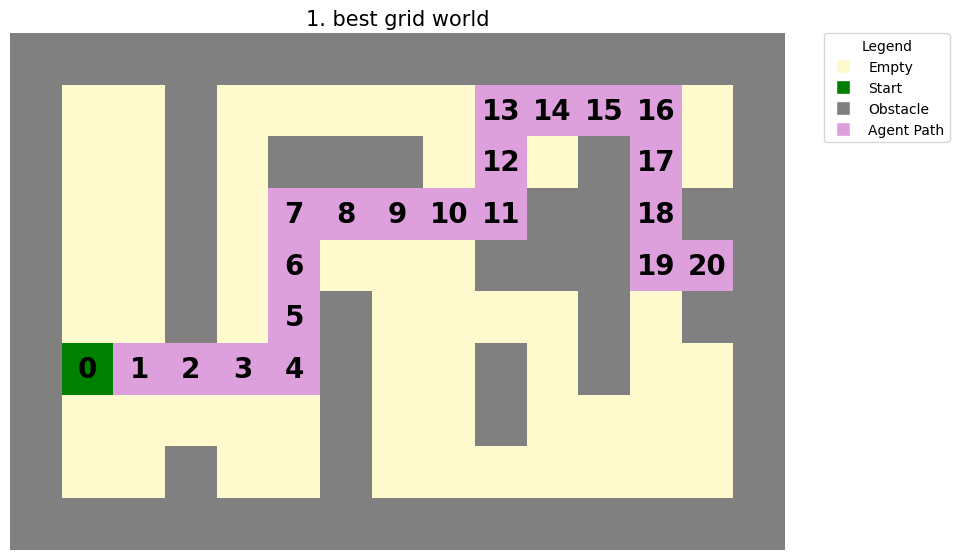

----------------------------------------------------------------------------------------------------

2. best grid world


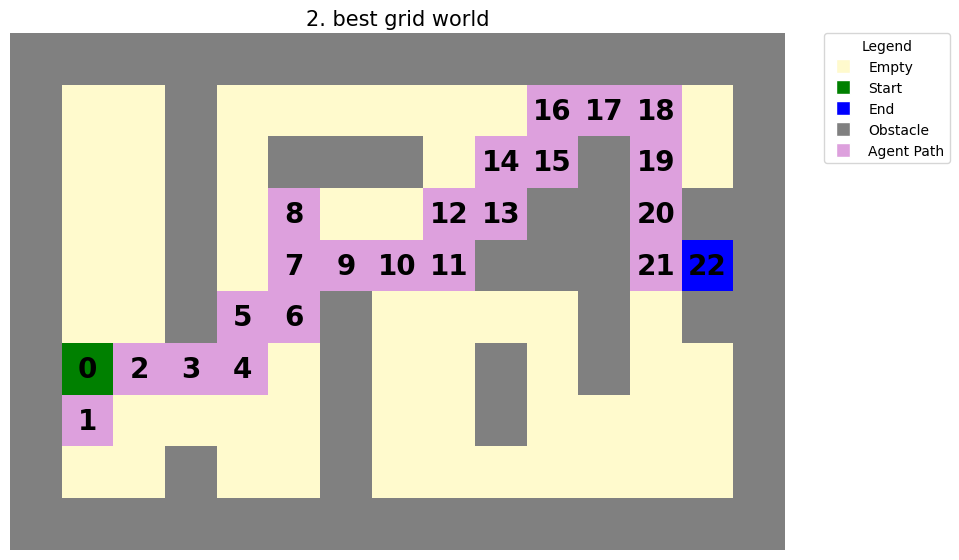

----------------------------------------------------------------------------------------------------

3. best grid world


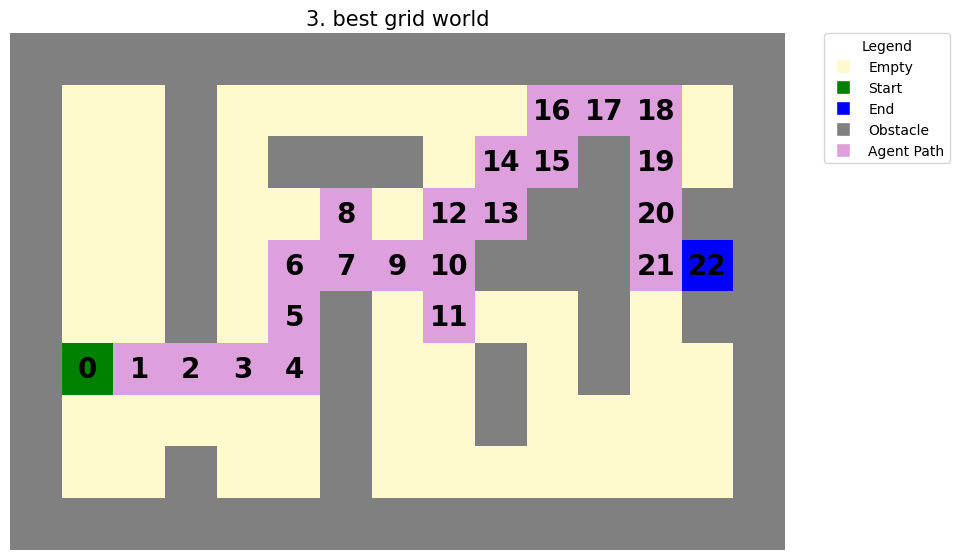

----------------------------------------------------------------------------------------------------

4. best grid world


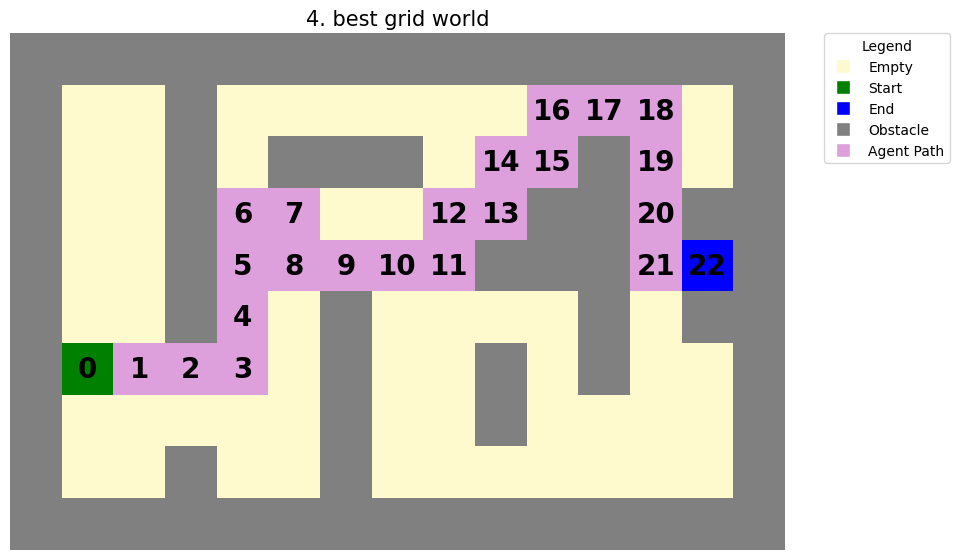

----------------------------------------------------------------------------------------------------

5. best grid world


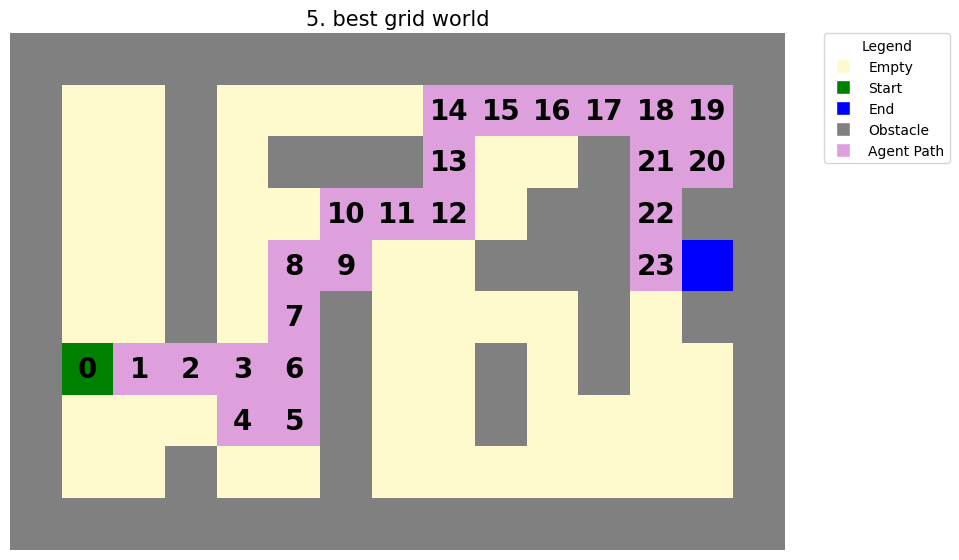

----------------------------------------------------------------------------------------------------



In [6]:
selected_paths, selected_indices = fn.find_different_paths(
    primary_fitness_scores = primary_fitness_scores, 
    secondary_fitness_scores = secondary_fitness_scores, 
    population_paths = population_paths,
    N = NUM_BEST_PATHS
)

for i, index in enumerate(selected_indices, 1):
    title = f"{i}. best grid world"
    print(title)
    fn.grid_world_visualization(grid_worlds[index], agent_path=population_paths[index], title=title, agent_flag=1)
    print(LINE)
    print()

### Pheromone matrix creation 

In [7]:
best_positions = []
for selected_path in selected_paths:        
    best_positions.extend(selected_path)

pheromones = ((PATH_SCALING_FACTOR - 1) * fn.create_pheromones_matrix(best_positions, GRID_SIZE) + 1) / PATH_SCALING_FACTOR


### Visualization the initial grid world with pheromone levels

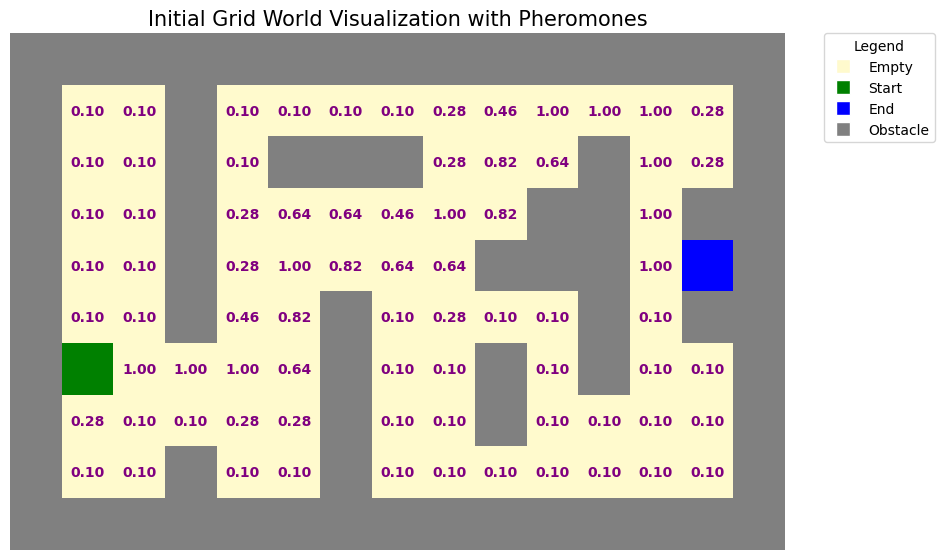

In [8]:
fn.grid_world_visualization(
    grid_world=initial_grid_world, 
    title="Initial Grid World Visualization with Pheromones", 
    show_pheromones=pheromones
)

## Simulation using ACO

In [9]:
results = sm.aco_simulation(
    num_iterations=NUM_ITERATIONS,
    num_ants=NUM_ANTS,
    start_position=START_POSITION,
    end_position=END_POSITION,
    initial_pheromones=pheromones,
    grid_world=initial_grid_world,
    alpha=ALPHA,
    beta=BETA,
    max_path_length=MAX_PATH_LENGTH,
    revisit_possible=ACO_REVISIT_POSSIBLE,
    evaporation_rate=EVAPORATION_RATE,
    deposit_factor=DEPOSIT_FACTOR,
    pheromone_normalization=PHEROMONE_NORMALIZATION,
    random_seed=RANDOM_STATE,
    num_optimal_steps=NUM_OPTIMAL_STEPS,
    pheromone_threshold=PHEROMONE_THRESHOLD,
    simulation_started_message=SIMULATION_STARTED,
    simulation_finished_message=SIMULATION_FINISHED,
    verbose="Full",
    line = LINE,
    double_line = DOUBLE_LINE   
)

best_paths = results[6]
best_scores = results[7]
median_scores = results[8]
mean_scores = results[9]
iteration = results[10]

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. iteration finished - best score: 0.0 - median score: 3.6056 - mean score: 3.871
----------------------------------------------------------------------------------------------------
 2. iteration finished - best score: 0.0 - median score: 5.099 - mean score: 3.9618
----------------------------------------------------------------------------------------------------
 3. iteration finished - best score: 0.0 - median score: 0.5 - mean score: 2.7032
----------------------------------------------------------------------------------------------------
 4. iteration finished - best score: 0.0 - median score: 0.0 - mean score: 1.8411
----------------------------------------------------------------------------------------------------
 5. iteration finished - best score: 0.0 - median score: 2.2361 - mean score: 2.0748
------------------------------------------------------------------------------

## Visualization the final grid world with pheromone levels

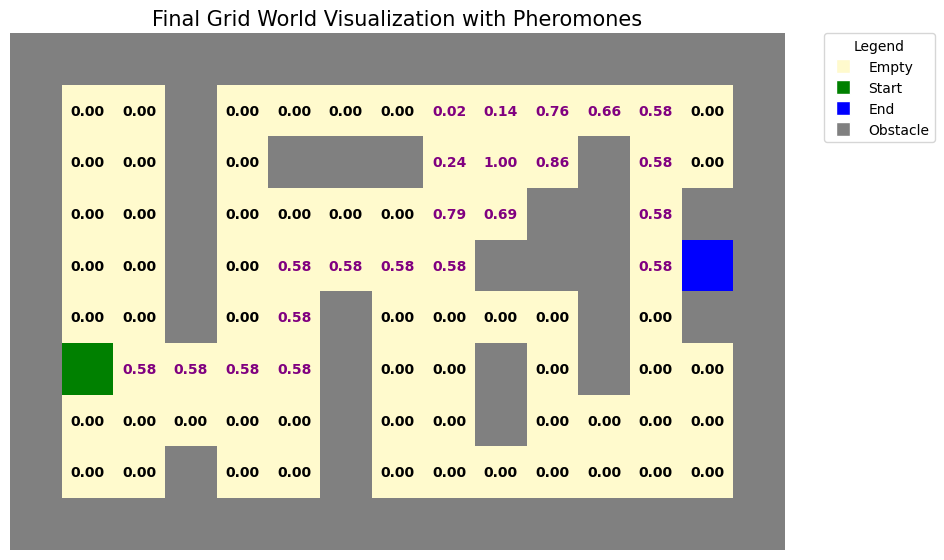

In [10]:
fn.grid_world_visualization(
    grid_world=initial_grid_world, 
    title="Final Grid World Visualization with Pheromones", 
    show_pheromones=pheromones
)

## Result scores visualization

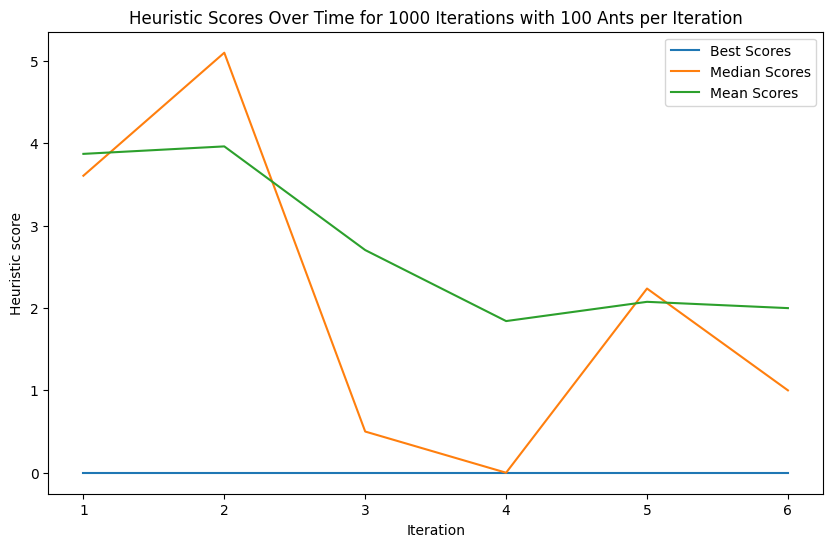

In [11]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title(f"Heuristic Scores Over Time for {NUM_ITERATIONS} Iterations with {NUM_ANTS} Ants per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Heuristic score")
plt.legend()

plt.show()

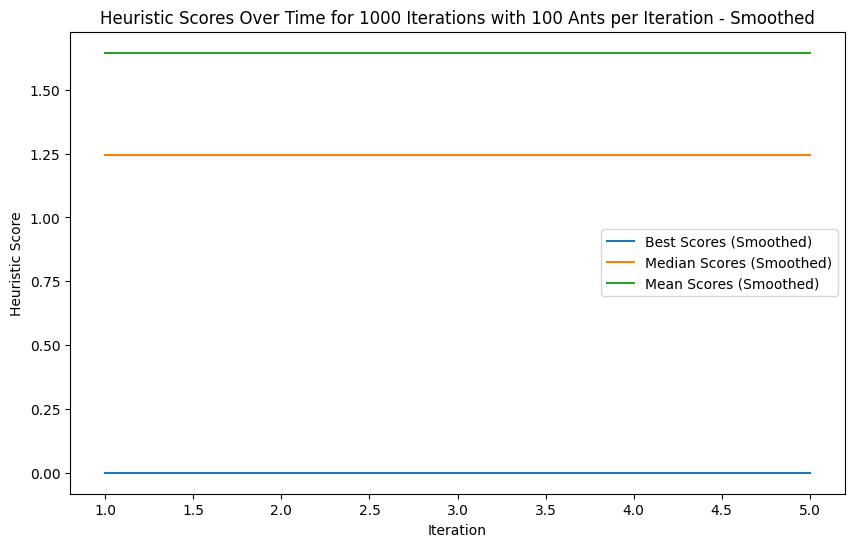

In [12]:
best_scores_smooth = fn.moving_average(best_scores, WINDOW_SIZE)
median_scores_smooth = fn.moving_average(median_scores, WINDOW_SIZE)
mean_scores_smooth = fn.moving_average(mean_scores, WINDOW_SIZE)

x_values_smooth = range(1, len(best_scores_smooth) + 1)

plt.figure(figsize=(10, 6))

plt.plot(x_values_smooth, best_scores_smooth, label="Best Scores (Smoothed)")
plt.plot(x_values_smooth, median_scores_smooth, label="Median Scores (Smoothed)")
plt.plot(x_values_smooth, mean_scores_smooth, label="Mean Scores (Smoothed)")

plt.title(f"Heuristic Scores Over Time for {NUM_ITERATIONS} Iterations with {NUM_ANTS} Ants per Iteration - Smoothed")
plt.xlabel("Iteration")
plt.ylabel("Heuristic Score")
plt.legend()

plt.show()


In [13]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)

print("Path reconstruction:")
fn.path_reconstruction(
    best_population_paths=best_paths, 
    initial_grid_world=initial_grid_world, 
    results_path=GA_ACO_VERSION_PATH, 
    start_position=START_POSITION, 
    end_position=END_POSITION, 
    step=int(iteration/10) if int(iteration/10) >= 1 else 1, 
    title_type="iteration", 
    path_flag=1
)

print(LINE)

print("Video creation...")
fn.video_creation(GA_ACO_VERSION_PATH, GA_ACO_VIDEO_PATH)
print("Video creation finished!")

print(DOUBLE_LINE)

PATHS RECONSTRUCTION AND VIDEO CREATION
Path reconstruction:


Processing generations/iterations: 100%|██████████| 6/6 [00:58<00:00,  9.76s/it]


----------------------------------------------------------------------------------------------------
Video creation...


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


Video saved to ./results/GA-ACO results/non-reentrant ga - reentrant aco/GA_ACO_results.mp4
Video creation finished!


frame=  126 fps=123 q=-1.0 Lsize=     177kB time=00:00:24.60 bitrate=  58.9kbits/s speed=  24x    
video:175kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.210800%
[libx264 @ 0x556069b5d880] frame I:1     Avg QP: 9.60  size: 21180
[libx264 @ 0x556069b5d880] frame P:86    Avg QP:16.02  size:  1619
[libx264 @ 0x556069b5d880] frame B:39    Avg QP:13.48  size:   456
[libx264 @ 0x556069b5d880] consecutive B-frames: 41.3% 49.2%  9.5%  0.0%
[libx264 @ 0x556069b5d880] mb I  I16..4: 81.7%  6.1% 12.2%
[libx264 @ 0x556069b5d880] mb P  I16..4:  1.7%  0.4%  0.7%  P16..4:  1.4%  0.1%  0.1%  0.0%  0.0%    skip:95.6%
[libx264 @ 0x556069b5d880] mb B  I16..4:  0.9%  0.2%  0.2%  B16..8:  1.6%  0.2%  0.0%  direct: 0.1%  skip:96.8%  L0:53.1% L1:45.6% BI: 1.3%
[libx264 @ 0x556069b5d880] 8x8 transform intra:12.8% inter:63.9%
[libx264 @ 0x556069b5d880] coded y,uvDC,uvAC intra: 11.8% 31.2% 25.3% inter: 0.4% 0.6% 0.5%
[libx264 @ 0x556069b5d880] i16 v,h,dc,p: 69% 29%  2%  0%
[li

In [14]:
Video(GA_ACO_VIDEO_PATH, embed=True)